# Learning Encodes Remote Homology.

In [13]:
# Needed to import modules from helpers
import sys
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import esm
from io import StringIO
from Bio import SeqIO

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from helpers import helper

from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

# Load ESM model to GPU

In [14]:
# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

# Get Data

In [15]:
# Download, Parse and Filter SCOP data
helper.download_no_requests()
df_scop = helper.parse_and_filter_scop()

if not df_scop.empty:
    print(f"Total sequences/domains retained: {len(df_scop)}")
    print(df_scop.head())

File already exists. Skipping download.
Parsing and filtering sequences...
Total sequences/domains retained: 12261
  domain_id                                           sequence class fold  \
0   d1dlwa_  slfeqlggqaavqavtaqfyaniqadatvatffngidmpnqtnkta...     a  a.1   
1   d2gkma_  gllsrlrkrepisiydkiggheaievvvedffvrvladdqlsaffs...     a  a.1   
2   d1ngka_  ksfydavggaktfdaivsrfyaqvaedevlrrvypeddlagaeerl...     a  a.1   
3   d2bkma_  eqwqtlyeaiggeetvaklveafyrrvaahpdlrpifpddltetah...     a  a.1   
4   d4i0va_  aslyeklggaaavdlavekfygkvladervnrffvntdmakqkqhq...     a  a.1   

  superfamily   family  
0       a.1.1  a.1.1.1  
1       a.1.1  a.1.1.1  
2       a.1.1  a.1.1.1  
3       a.1.1  a.1.1.1  
4       a.1.1  a.1.1.1  


In [16]:
# TODO: Remove this cell, its only because we can process such amounts of sequences on cpu
df_scop = df_scop.sample(500)

In [17]:
# Extract the domains_id's and the actual domain sequences from the DataFrame
labels = df_scop['domain_id'].tolist()
seqs = [s.upper() for s in df_scop['sequence'].tolist()]

In [18]:
# 1. Embeddings mit dem TRAINIERTEN Modell holen
print(f"Berechne TRAINIERTE Embeddings für {len(seqs)} Sequenzen...")

# Schritt 1: Hidden Representations holen
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(model, alphabet, labels, seqs)

# Schritt 2: Mean Pooling durchführen
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

print("Fertig!")
print(f"Erstellte Embeddings: {len(emb_trained)}")

Berechne TRAINIERTE Embeddings für 500 Sequenzen...
Processing 500 sequences in batches of 1...
Fertig!
Erstellte Embeddings: 500


### General Claim: 
If structural homology is encoded in the metric structure of the representation space, then the distance between protein embeddings reflects their degree of structural relatedness.

### Hypothesis 1:
Proteins of same superfamily are closer in the representation space then to proteins of other superfamilies.

Implication: Model understands without labels to cluster sequences into their superfamilies

In [19]:
# Calculate the Similarity Matrix (Cosine Similarity)
# The paper relies on vector similarity (cosine) for nearest neighbor queries [cite: 211, 219]
print("Calculating similarity matrix...")
sim_matrix = cosine_similarity(emb_trained)
#print(sim_matrix.shape)

# Ensure labels are numpy arrays for boolean indexing
families = np.array(df_scop['family'].values)
superfamilies = np.array(df_scop['superfamily'].values)

# 2. EVALUATION LOOP (Superfamily Level)
sf_auc_scores = []
sf_hits_at_10 = []
sf_hits_at_1 = []

print(f"Evaluating Superfamily Homology on {len(emb_trained)} sequences...")

# Loop over each hidden layer representation
for i in range(len(emb_trained)):
    # Define Mask
    # As per the methodology: "For evaluation at the superfamily level...
    # domains belonging to the same family are excluded." [cite: 209]
    
    # 1. POSITIVE: Same Superfamily as query (i)
    # print(superfamilies[i])
    is_same_superfamily = (superfamilies == superfamilies[i])
    
    # 2. POSITIVE BUT EXCLUDED: Same Family as query (i)
    # print(families[i])
    is_same_family = (families == families[i])
    
    # 3. VALID SEARCH SPACE: Everything EXCEPT the same family
    # (We mask out the query itself and its close family members)
    not_same_family = ~is_same_family
    
    # 4. FINAL MASK: Same Superfamily AND not in the same Family
    positive_mask = is_same_superfamily & not_same_family
    
    # Skip if there are no valid positives for this protein (cannot calc AUC)
    if np.sum(positive_mask) == 0:
        #print(f"Skipping index {i} - no valid positives.")
        continue
    
    # Filter Scores & Labels
    # Go through the i'th row of the similarity matrix and get the similarity scores for the ones which are of a different family
    y_scores = sim_matrix[i][not_same_family]
    #print(y_scores)
    # Get boolean labels for the ones which are of the same superfamily (but different family)
    y_true = positive_mask[not_same_family]
    #print(y_true)
    
    # Calculate AUC
    # Measures the density of homologous proteins in the neighborhood
    # auc = 1 if top hits are all true positives, 0.5 for random ranking 
    auc = roc_auc_score(y_true, y_scores)
    sf_auc_scores.append(auc)
    
    # Calculate Hit-10
    # "Hit-10... gives the probability of recovering a remote homolog (same superfamily)
    # in the 10 highest ranked results / most similar" [cite: 210]
    # Hit-10 is 1 if at least one of the top 10 is a true positive, else 0
    sorted_indices = np.argsort(-y_scores) # Descending sort
    top_10_indices = sorted_indices[:10]
    
    if np.any(y_true[top_10_indices]):
        sf_hits_at_10.append(1)
    else:
        sf_hits_at_10.append(0)

    top_1_indices = sorted_indices[:1]
    
    if np.any(y_true[top_1_indices]):
        sf_hits_at_1.append(1)
    else:
        sf_hits_at_1.append(0)

print("\n SUPERFAMILY LEVEL RESULTS")
print(f"Mean ROC-AUC: {np.mean(sf_auc_scores):.4f}")
# Ideally above 1 for a good model (there is always a true positive in the top 10)
print(f"Mean Hit-10:  {np.mean(sf_hits_at_10):.4f}")
print(f"Mean Hit-1:  {np.mean(sf_hits_at_1):.4f}")

Calculating similarity matrix...
Evaluating Superfamily Homology on 500 sequences...

 SUPERFAMILY LEVEL RESULTS
Mean ROC-AUC: 0.8521
Mean Hit-10:  0.7062
Mean Hit-1:  0.5735


### Additional (Not in Paper Visualization)

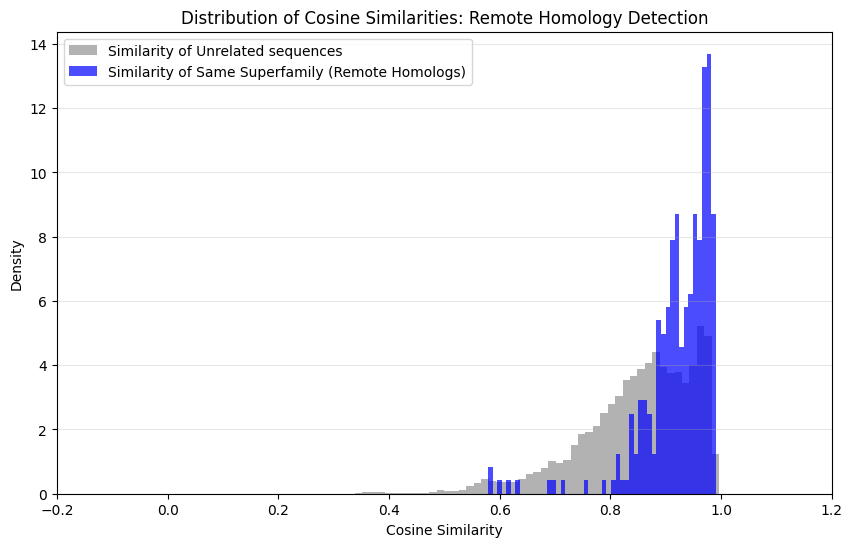

Mean Similarity (Remote Homologs): 0.9227
Mean Similarity (Unrelated):       0.8491
Number of pairs (Homologs):        586
Number of pairs (Unrelated):       248636


In [20]:
# Create boolean masks for all pairs
# Broadcasting: (N, 1) == (1, N) -> (N, N) boolean matrix
mask_same_sf = superfamilies[:, None] == superfamilies[None, :]
mask_same_fam = families[:, None] == families[None, :]

# DEFINITION OF GROUPS
# Group A: Remote Homologs ("Aligned" equivalent)
# Same Superfamily AND NOT Same Family (excludes self-hits and easy trivial matches)
mask_remote_homologs = mask_same_sf & (~mask_same_fam)

# Group B: Unrelated ("Unaligned" equivalent)
# Different Superfamily
mask_unrelated = ~mask_same_sf

# Extract the cosine similarity values using the masks
scores_homologs = sim_matrix[mask_remote_homologs]
scores_unrelated = sim_matrix[mask_unrelated]

# --- 2. PLOT DISTRIBUTION ---
plt.figure(figsize=(10, 6))

# Plot 'Unrelated' (Background)
plt.hist(scores_unrelated, bins=50, alpha=0.6, color='grey', 
         label='Similarity of Unrelated sequences', density=True)

# Plot 'Remote Homologs' (Signal)
plt.hist(scores_homologs, bins=50, alpha=0.7, color='blue', 
         label='Similarity of Same Superfamily (Remote Homologs)', density=True)

# Formatting to match the style of the paper
plt.title('Distribution of Cosine Similarities: Remote Homology Detection')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.xlim(-0.2, 1.2)

plt.show()

# --- 3. PRINT STATISTICS ---
print(f"Mean Similarity (Remote Homologs): {np.mean(scores_homologs):.4f}")
print(f"Mean Similarity (Unrelated):       {np.mean(scores_unrelated):.4f}")
print(f"Number of pairs (Homologs):        {len(scores_homologs)}")
print(f"Number of pairs (Unrelated):       {len(scores_unrelated)}")

### Hypothesis 2:
proteins that have the same fold even if they are of different superfamilies (filter) are closer to each other in the representation space than proteins of different superfamilies which dont have the fold. 

In [21]:
# 2. Prepare Labels to create masks for Remote Homology Detection (Fold Level)
folds = df_scop['fold'].values
superfamilies = df_scop['superfamily'].values

# 3. Evaluation Loop
auc_scores = []
hits_at_10 = []

print(f"Evaluating Remote Homology on {len(emb_trained)} sequences...")

for i in range(len(emb_trained)):
    # Define Masks
    # Positive: Same Fold as query (i)
    is_same_fold = (folds == folds[i])
    
    # Exclude: Same Superfamily as query (i) - The "easy" matches
    is_same_superfamily = (superfamilies == superfamilies[i])
    
    # We want to find Same Fold BUT Different Superfamily
    # So we ignore anything that IS same superfamily
    not_same_superfamily = ~is_same_superfamily
    
    # Identify Positives (Target Class) among the valid items
    # (Same Fold AND NOT Same Superfamily)
    positive_mask = is_same_fold & not_same_superfamily
    
    # If there are no remote homologs for this protein, skip it
    if np.sum(positive_mask) == 0:
        continue
        
    # Filter Scores & Labels
    # Get scores for all valid candidates (exclude same superfamily)
    y_scores = sim_matrix[i][not_same_superfamily]
    y_true = positive_mask[not_same_superfamily]
    
    # Calculate AUC
    # How well does the score distinguish same-fold from different-fold?
    auc = roc_auc_score(y_true, y_scores)
    auc_scores.append(auc)
    
    # Calculate Hit-10
    # Sort indices by score (descending) to get rankings
    # We only care if a Positive appears in the top 10
    sorted_indices = np.argsort(-y_scores) # Descending sort
    top_10_indices = sorted_indices[:10]
    
    # Check if ANY of the top 10 are positives
    if np.any(y_true[top_10_indices]):
        hits_at_10.append(1)
    else:
        hits_at_10.append(0)

# --- 4. Final Results ---
print("\n--- FOLD RESULTS ---")
print(f"Mean ROC-AUC: {np.mean(auc_scores):.4f}")
print(f"Mean Hit-10:  {np.mean(hits_at_10):.4f}")

Evaluating Remote Homology on 500 sequences...

--- FOLD RESULTS ---
Mean ROC-AUC: 0.6873
Mean Hit-10:  0.5700


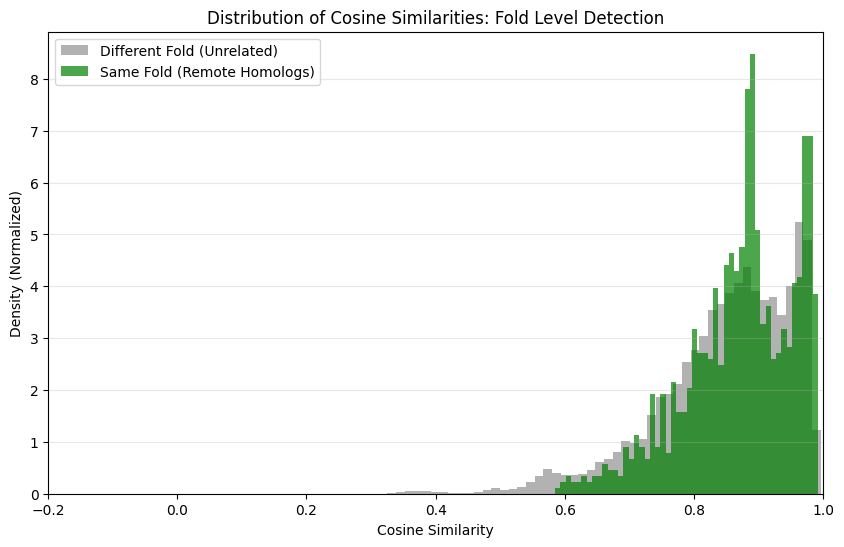

Mean Similarity (Same Fold, Diff SF): 0.8711
Mean Similarity (Unrelated):          0.8489
Gap:                                  0.0222


In [22]:
# SETUP MASKS
# We use broadcasting to create (N, N) boolean matrices for all pairs

# Check where Folds are the same
mask_same_fold = folds[:, None] == folds[None, :]

# Check where Superfamilies are the same (The "Easy" matches to exclude)
mask_same_sf = superfamilies[:, None] == superfamilies[None, :]

# DEFINE DISTRIBUTIONS

# Remote Homologs (The Signal)
# Logic: Matches that share the Fold, but are NOT in the same Superfamily
mask_signal = mask_same_fold & (~mask_same_sf)

# Unrelated (The Background)
# Logic: Different Fold AND NOT in the same Superfamily 
# (We exclude same-superfamily here too, to match the 'valid_mask' used in your evaluation loop)
mask_background = (~mask_same_fold) & (~mask_same_sf)

# EXTRACT SCORES
scores_signal = sim_matrix[mask_signal]
scores_background = sim_matrix[mask_background]

plt.figure(figsize=(10, 6))

# Plot Background (Unrelated)
plt.hist(scores_background, bins=50, alpha=0.6, color='grey', density=True,
         label='Different Fold (Unrelated)')

# Plot Signal (Same Fold)
plt.hist(scores_signal, bins=50, alpha=0.7, color='green', density=True,
         label='Same Fold (Remote Homologs)')

# Formatting
plt.title('Distribution of Cosine Similarities: Fold Level Detection')
plt.xlabel('Cosine Similarity')
plt.ylabel('Density (Normalized)')
plt.legend(loc='upper left')
plt.grid(axis='y', alpha=0.3)

# Focus the x-axis on the relevant positive region if desired
plt.xlim(-0.2, 1.0) 

plt.show()

# STATS
print(f"Mean Similarity (Same Fold, Diff SF): {np.mean(scores_signal):.4f}")
print(f"Mean Similarity (Unrelated):          {np.mean(scores_background):.4f}")
print(f"Gap:                                  {np.mean(scores_signal) - np.mean(scores_background):.4f}")